In [360]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import os

#from utils import *

exp_type = 'OD'

# Specify the file path
base_path = "/Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB"
file_path = os.path.join(base_path, "OD600.csv")

# Load the CSV file into a DataFrame
data = pd.read_csv(file_path)

data['Time (mins)'] = data['Time (mins)']/60
data = data.rename(columns={'Time (mins)': 'Time (hrs)'})


# Display the first few rows of the DataFrame
print(data.head())


   Time (hrs)     A1     A2     A3     A4     A5     A6     A7     A8     A9  \
0    0.000000  0.203  0.197  0.209  0.184  0.195  0.191  0.209  0.216  0.202   
1    0.333333  0.172  0.162  0.181  0.181  0.172  0.179  0.190  0.185  0.179   
2    0.666667  0.161  0.161  0.182  0.176  0.166  0.165  0.181  0.182  0.173   
3    1.000000  0.165  0.164  0.184  0.176  0.170  0.170  0.188  0.191  0.185   
4    1.333333  0.167  0.167  0.188  0.179  0.176  0.172  0.199  0.202  0.196   

   ...     H3     H4     H5     H6     H7     H8     H9    H10    H11    H12  
0  ...  0.164  0.172  0.165  0.177  0.168  0.166  0.169  0.152  0.156  0.160  
1  ...  0.161  0.170  0.166  0.177  0.169  0.175  0.167  0.154  0.157  0.163  
2  ...  0.166  0.172  0.167  0.181  0.168  0.169  0.164  0.154  0.158  0.163  
3  ...  0.162  0.168  0.165  0.167  0.165  0.161  0.159  0.155  0.157  0.163  
4  ...  0.161  0.166  0.165  0.169  0.165  0.166  0.160  0.155  0.158  0.163  

[5 rows x 97 columns]


In [361]:
### Function: saving data generated. First indicate the data that you to be saved, 
### then indicate the file name


def save_csv(data_to_save, filename): 
    save_path = os.path.join(base_path, filename)
    data_to_save.to_csv(save_path, index=False)
    print(f"{filename} successfully saved to {save_path}")




### function: change the name of the columns to the actual sample names 
### indicate the well map csv file name 

def map_to_colname(file_name, exp_type = exp_type, p = False): 
    file_path = os.path.join(base_path, file_name)
    
    well_map = pd.DataFrame()
    well_map = pd.read_csv(file_path, index_col = 0)
    
    well_ids = []
    sample_names = []
    for row in well_map.index: 
        for col in well_map.columns: 
            well_ids.append(f"{row}{col}")
            if pd.isna(well_map.at[row, col]):
                sample_names.append('No Sample')  # Replace missing value with 'No Sample' or another placeholder
            else:
                sample_names.append(well_map.at[row, col])
                
    reshaped_map = pd.DataFrame({'Well': well_ids,'Sample': sample_names})
    # Create a dictionary that maps well names (e.g., 'A1', 'A2', ...) to sample names
    well_to_sample = dict(zip(reshaped_map['Well'], reshaped_map['Sample']))

    # Extract the well names from your data columns (excluding "Time (hrs)")
    well_names = data.columns[1:]  # Exclude "Time (hrs)"

    # Map the sample names to the well names (using the well_to_sample dictionary)
    mapped_column_names = ['Time (hrs)'] + [well_to_sample.get(well, well) for well in well_names]

    # Assign the new column names to your data
    data.columns = mapped_column_names
    if p == True: 
        print(data)
    save_csv(data, f"{exp_type} data with sample names.csv")



def avg_and_std(exp_type = exp_type, df = data, p=False): 
    
    # Step 1: Identify columns with the same names
    # First, we'll drop the "Time (hrs)" column to focus only on the sample columns
    columns_to_process = df.drop(columns='Time (hrs)')

    # Step 2: Group the columns by name and calculate the mean and standard deviation for each row
    averaged = columns_to_process.T.groupby(columns_to_process.columns).mean().T
    std_dev = columns_to_process.T.groupby(columns_to_process.columns).std().T

    # Step 3: Reinsert the "Time (hrs)" column back to the averaged and standard deviation data
    averaged.insert(0, 'Time (hrs)', df['Time (hrs)'])
    std_dev.insert(0, 'Time (hrs)', df['Time (hrs)'])

    # drop columns called No Sample
    averaged = averaged.drop('No Sample', axis=1)
    std_dev = std_dev.drop('No Sample', axis=1)

    # Step 4: Display the result if requested
    if p == True: 
        print("Averaged Data:")
        print(averaged)
        print("\nStandard Deviation Data:")
        print(std_dev)
    
    # Save as csv
    save_csv(averaged, f"{exp_type} averaged by column name.csv")
    save_csv(std_dev, f"{exp_type} standard deviation by column name.csv")

    # Return both the averaged and standard deviation DataFrames
    return averaged, std_dev




### Function: average by column name 
### indicate the dataframe you want to average, set p to True if you want to see the result printed 

def avg(exp_type = exp_type, df = data, p=False): 
    
    # Step 1: Identify columns with the same names
    # First, we'll drop the "Time (hrs)" column to focus only on the sample columns
    columns_to_average = df.drop(columns='Time (hrs)')

    # Step 2: Group the columns by name and calculate the mean for each row
    averaged = columns_to_average.T.groupby(columns_to_average.columns).mean().T

    # Step 3: Reinsert the "Time (hrs)" column back to the averaged data
    averaged.insert(0, 'Time (hrs)', df['Time (hrs)'])

    # drop columns called No Sample
    averaged = averaged.drop('No Sample', axis=1)

    # Step 4: Display the result
    if p == True: 
        print(averaged)
    
    # save as csv 
    save_csv(averaged, f"{exp_type} averaged by column name.csv")

    #return the averaged DataFrame so we can access it with other functions 
    return averaged 




#### function for doubling time
import numpy as np
from scipy.stats import linregress





def calculate_doubling_times_per_replicate(df, time_col='Time (hrs)', min_od=0.1, max_od=0.35, p=False):
    """
    Calculates doubling time for each replicate (even with duplicate column names).
    
    Parameters:
    - df: DataFrame with 'Time (hrs)' and replicates.
    - time_col: Name of time column.
    - min_od, max_od: OD range for exponential phase.
    - p: Print the resulting DataFrame.
    
    Returns:
    - DataFrame with Sample and Doubling Time (hrs)
    """
    results = []

    time = df[time_col].values

    # Loop through all columns *by position* (index), not name
    for idx, col_name in enumerate(df.columns):
        if col_name == time_col:
            continue

        od = df.iloc[:, idx].values  # safely get column even if name is duplicated

        mask = (od >= min_od) & (od <= max_od)
        if np.sum(mask) < 3:
            continue

        time_exp = time[mask]
        log_od = np.log(od[mask])
        slope, _, _, _, _ = linregress(time_exp, log_od)

        doubling_time = np.log(2) / slope if slope > 0 else np.nan

        results.append({'Sample': col_name, 'Doubling Time (hrs)': doubling_time})

    df_out = pd.DataFrame(results)
    if p:
        print(df_out)
    save_csv(df_out, "Doubling times per replicate.csv")
    return df_out



# now we want to divide the fluorescence by OD600 
def deduplicate_columns(columns):
    seen = {}
    new_columns = []
    for col in columns:
        if col not in seen:
            seen[col] = 0
            new_columns.append(col)
        else:
            seen[col] += 1
            new_columns.append(f"{col}.{seen[col]}")
    return new_columns

def remove_suffix(name):
    return name.split('.')[0]  # e.g., 'Neg (∆pro).1' → 'Neg (∆pro)'


from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def run_statistical_analysis(df, selected_strains):
    """
    Perform ANOVA and post-hoc Tukey test on selected strains.
    """
    # Filter to selected strains
    subset = df[df['Sample'].isin(selected_strains)]

    # Group doubling times by strain
    grouped = subset.groupby('Sample')['Doubling Time (hrs)'].apply(list)

    # Ensure at least 2 replicates per group
    valid_groups = [g for g in grouped if len(g) > 1]
    if len(valid_groups) < 2:
        print("Not enough replicates for statistical comparison.")
        return

    # Run one-way ANOVA
    f_stat, p_val = f_oneway(*valid_groups)
    print(f"ANOVA p-value: {p_val:.4f}")

    # Tukey post-hoc test
    tukey = pairwise_tukeyhsd(subset['Doubling Time (hrs)'], subset['Sample'])
    print("\nPost-hoc Tukey HSD results:")
    print(tukey.summary())

    # Optional: return results for programmatic use
    return tukey



### Function: blank correction 

def blank_correct(blank, df, exp_type = exp_type, p = False): 
    corrected_columns = []

    for col in df.columns: 
        if col != 'Time (hrs)' and col != blank: 
            corrected_columns.append(df[col] - df[blank])

    blank_corrected = pd.concat(corrected_columns, axis=1)
    blank_corrected.columns = [col for col in df.columns if col != 'Time (hrs)' and col != blank]
    blank_corrected.insert(0, 'Time (hrs)', data['Time (hrs)'])

    if p == True: 
        print(blank_corrected) 
    save_csv(blank_corrected, f"{blank} blank_corrected {exp_type}.csv")
    
    return blank_corrected











    ### Function: selecting appropriate neg ctrls and autofluorescence correction 


def select_ctrls(df): 
    lst_strains = []

    for col in df.columns: 
        if 'Neg' in col: 
            lst_strains.append(col)

    print('Selected negative ctrl strains:', lst_strains)
    return lst_strains




def autofluor_correct(ctrl_strains, df, p = False): 
    # List to store all the corrected columns
    corrected_columns = []

    # Iterate over each control strain
    for strain in ctrl_strains: 
        # Extract the background from the control strain (e.g., 'JW0377' from 'Neg (JW0377)')
        ctrl_background = strain.split(' ')[-1].strip('()')


        # Iterate through the columns in df and subtract fluorescence for test strains matching the control background
        for col in df.columns: 
            if col != 'Time (hrs)' and ctrl_background in col:
                corrected_columns.append(df[col] - df[strain])



    # Create a single DataFrame with all the corrected fluorescence values for the test strains
    df_corrected = pd.concat(corrected_columns, axis=1)
    df_corrected = df_corrected.drop(columns= ctrl_strains)


    # Match column names to the correct test strains (excluding 'Time (hrs)' and the control strain)
    df_corrected.columns = [col for col in df.columns if col != 'Time (hrs)' and all(strain not in col for strain in ctrl_strains)]

    #print(df_corrected)


    # Reinsert 'Time (hrs)' column back to the corrected DataFrame
    df_corrected.insert(0, 'Time (hrs)', df['Time (hrs)'])

    # If p is True, print the corrected DataFrame
    if p==True:
        #print("Corrected data:")
        print(df_corrected)

    return df_corrected






### function to assign color 
# Function to assign colors based on fluorescence protein and strain name in the column name
def straintest_assign_color(column_name):
    if "sfGFP" in column_name:
        return 'cyan'
    elif "mCherry" in column_name:
        return 'magenta'

    elif "mKate" in column_name: 
        return 'pink'

    elif "mRFP1" in column_name: 
        return 'orange'
    elif "∆pro" in column_name: 
        return 'blue'
    elif "∆trp" in column_name: 
        return 'brown' 
    elif "MG" in column_name: 
        return 'grey' 


def CF_assign_color(column_name):
    if "∆pro and ∆trp" in column_name: 
        if "no sup" in column_name: 
            return 'mediumvioletred' 
        elif 'sup' in column_name: 
            return ''
        elif 'Neg' in column_name: 
            return 'deeppink'
    if "no sup" in column_name:
        if "∆pro" in column_name: 
            return 'lightblue'
        elif "∆trp" in column_name: 
            return 'tan'
        elif "MG" in column_name: 
            return 'lightgray'
    if "sup" in column_name:
        if "∆pro" in column_name: 
            return 'cornflowerblue'
        elif "∆trp" in column_name: 
            return 'chocolate'
        elif "MG" in column_name: 
            return 'gray'
    if "Neg" in column_name: 
        if "∆pro" in column_name: 
            return 'blue'
        elif "∆trp" in column_name: 
            return 'brown' 
        elif "MG" in column_name: 
            return 'black'


def fluor_assign_color(column_name): 
    if "∆pro" in column_name: 
        return 'blue'
    elif "∆trp" in column_name: 
        return 'brown' 
    elif "MG" in column_name: 
        return 'grey' 


# Function to assign the appropriate color based on the medium type (LB or M9)
def assign_color(column_name, blank):
    if blank == "straintest":
        return straintest_assign_color(column_name)
    elif blank == "CF":
        return CF_assign_color(column_name)
    elif blank == "fluor": 
        return fluor_assign_color(column_name)



#### function for saving figures 

def save_fig(file_name): 
    figure_folder = os.path.join(base_path, "figures")
    os.makedirs(figure_folder, exist_ok = True) 
    save_path = os.path.join(figure_folder, file_name)
    plt.savefig(save_path, dpi = 300, bbox_inches = 'tight')
    print(f"figures saved to: {save_path}")



## function to make and customize plot 

def make_plot(df, blank, xlim, ylim, ylabel, title, xlabel = 'Time (hrs)', figsize = (8,6), tick_fontweight = 'bold', 
                   linewidth = 4, spine_linewidth=3, tick_width=3, s = True, fontsize = 25):
    selected_data = df[["Time (hrs)"] + selected_columns]
    plt.figure(figsize=figsize)
    for column in selected_columns:
        color = assign_color(column, blank)
        
        # Get the mean and standard deviation from the averaged and std_dev DataFrames
        mean_values = df[column]
        std_dev_values = std_dev[column]
        
        # Plot the mean line
        plt.plot(averaged["Time (hrs)"], mean_values, color=color, label=column, linewidth=linewidth)
        
        # Plot the shaded area for the error (standard deviation)
        plt.fill_between(averaged["Time (hrs)"], 
                         mean_values - std_dev_values, 
                         mean_values + std_dev_values, 
                         color=color, alpha=0.3)  # alpha for transparency
        #plt.plot(selected_data["Time (hrs)"], selected_data[column], color = color, label=column, linewidth = linewidth)

    """
    Automates the customization of a plot.
    
    Parameters:
    - ax: The axis object to customize.
    - xlim, ylim: Limits for the x and y axes.
    - xlabel, ylabel: Labels for the x and y axes.
    - title: Title of the plot.
    - figsize: size of figure 
    - linewidth: thickness of line in plot 
    - tick_fontweight: Font weight for the tick labels.
    - spine_linewidth: Line width for the spines.
    - tick_width: Width of the tick marks.
    """
    # Set axis limits
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    # Set labels and title
    plt.xlabel(xlabel, weight='bold', fontsize = fontsize)
    plt.ylabel(ylabel, weight='bold', fontsize = fontsize)
    #plt.title(title, weight='bold')

    font = fm.FontProperties(family= 'Arial', weight='bold', size = fontsize)

    # Customize the legend
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', frameon=False, prop = font) #(1.05, 1) #upper right, (1, 1) lower right (1, 0.05)
    #upper left: (0,1)
    # Customize spines (axes borders)
    ax = plt.gca()
    ax.spines['left'].set_linewidth(spine_linewidth)  
    ax.spines['bottom'].set_linewidth(spine_linewidth)
    for tick in ax.get_xticklabels():
        tick.set_fontweight(tick_fontweight)  # Set font weight to bold for x-tick label
        tick.set_fontsize(fontsize)
    for tick in ax.get_yticklabels():
        tick.set_fontweight(tick_fontweight)
        tick.set_fontsize(fontsize)

        
    plt.tick_params(axis='both', width= tick_width)  # Make tick marks bolder
    
    plt.tight_layout()

    if s == True: 
        save_fig(f"{title}.png")




import matplotlib.pyplot as plt
import numpy as np

def make_bar_plot(df, barwidth = 0.8, blank='straintest', title="Doubling Time of Strains", ylabel="DT (hrs)", 
                  xlabel="", figsize=(8, 6), fontsize=25, tick_fontweight='bold', linewidth = 3.5, 
                  spine_linewidth=3, tick_width=3, xlim=None, ylim=None, s=False):
    """
    Plots a bar graph with error bars and custom coloring from assign_color().
    
    Parameters:
    - df: DataFrame with columns ['Sample', 'Doubling Time (hrs)', 'Error'].
    - blank: Used to select the color assignment function.
    - s: Whether to save the figure.
    """
    plt.figure(figsize=figsize)
    
    # Bar positions
    x = np.arange(len(df['Sample']))
    heights = df['Doubling Time (hrs)']
    errors = df['Error']
    
    # Assign bar colors using your assign_color() function
    colors = [assign_color(sample, blank) for sample in df['Sample']]

    # Plot bars with error bars
    bars = plt.bar(x, heights, yerr=errors, capsize=8, color=colors, edgecolor='black', linewidth = linewidth, width = barwidth)

    # Annotate bar heights
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if not np.isnan(height):
            plt.annotate(f"{height:.2f}", 
                         xy=(bar.get_x() + bar.get_width()/2 , height+0.1),
                         xytext=(0, 3), textcoords="offset points",
                         ha='center', fontsize=20, weight='bold')

    # Axis labels
    plt.ylabel(ylabel, fontsize=fontsize, weight='bold')
    plt.xlabel(xlabel, fontsize=fontsize, weight='bold')

    # Axis limits
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    # Tick labels
    plt.xticks(x, df['Sample'], rotation=45, ha='right', fontsize=fontsize-10, weight=tick_fontweight)
    plt.yticks(fontsize=fontsize-10, weight=tick_fontweight)

    # Spine styling
   # ax = plt.gca()
   # ax.spines['left'].set_linewidth(spine_linewidth)
  #  ax.spines['bottom'].set_linewidth(spine_linewidth)
    ax = plt.gca()
    ax.spines['left'].set_linewidth(spine_linewidth)  
    ax.spines['bottom'].set_linewidth(spine_linewidth)
    for tick in ax.get_xticklabels():
        tick.set_fontweight(tick_fontweight)  # Set font weight to bold for x-tick label
        tick.set_fontsize(fontsize)
    for tick in ax.get_yticklabels():
        tick.set_fontweight(tick_fontweight)
        tick.set_fontsize(fontsize)
    plt.tick_params(axis='both', width=tick_width)

    #plt.yticks(np.arange(-3,1.5, step=0.5))  # ticks at 0, 2, 4, ..., 10


    plt.tight_layout()

    # Save figure if requested
    if s:
        save_fig(f"{title}.png")

    plt.show()









In [362]:
map_to_colname("well map.csv")
#averaged_data = avg()
averaged, std_dev = avg_and_std()
blank_corrected_data = blank_correct('LB', df = averaged)
doubling_times_df = calculate_doubling_times(averaged, p=True)


#neg_ctrl_strains = select_ctrls(blank_corrected_data) 
#autofluor_corrected = autofluor_correct(neg_ctrl_strains, blank_corrected_data) 









OD data with sample names.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/OD data with sample names.csv
OD averaged by column name.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/OD averaged by column name.csv
OD standard deviation by column name.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/OD standard deviation by column name.csv
LB blank_corrected OD.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/LB blank_corrected OD.csv
         Sample  Doubling Time (hrs)
0            LB                  NaN
1    MG_mCherry             3.341162
2      MG_sfGFP             3.863786
3      Neg (MG)             1.256397
4    Neg (∆pro)             1.332974
5    Neg (∆trp)             1.3257

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/figures/4.png


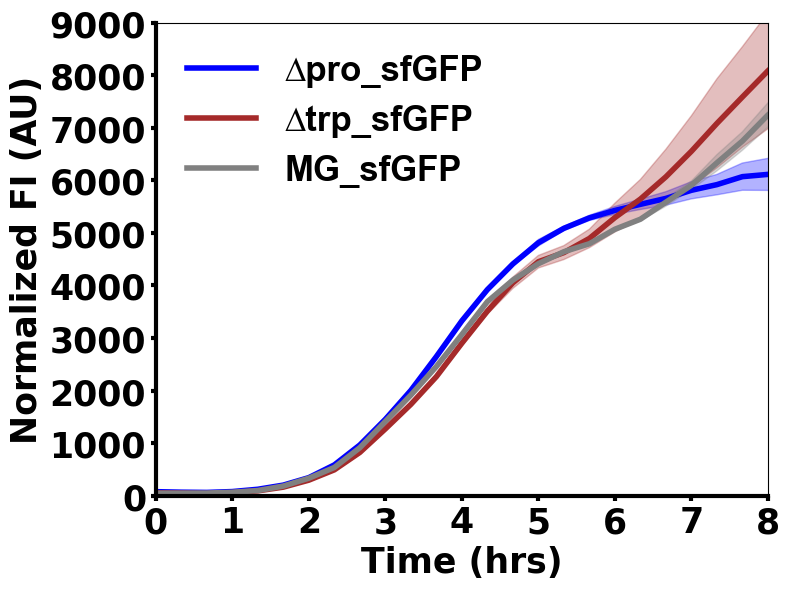

In [359]:
selected_columns = ["∆pro_sfGFP", '∆trp_sfGFP', 'MG_sfGFP']
make_plot(autofluor_corrected, blank = 'fluor', xlim = (0, 8), ylim = (0, 9000), 
          ylabel = "Normalized FI (AU)", title = '4', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/figures/5.png


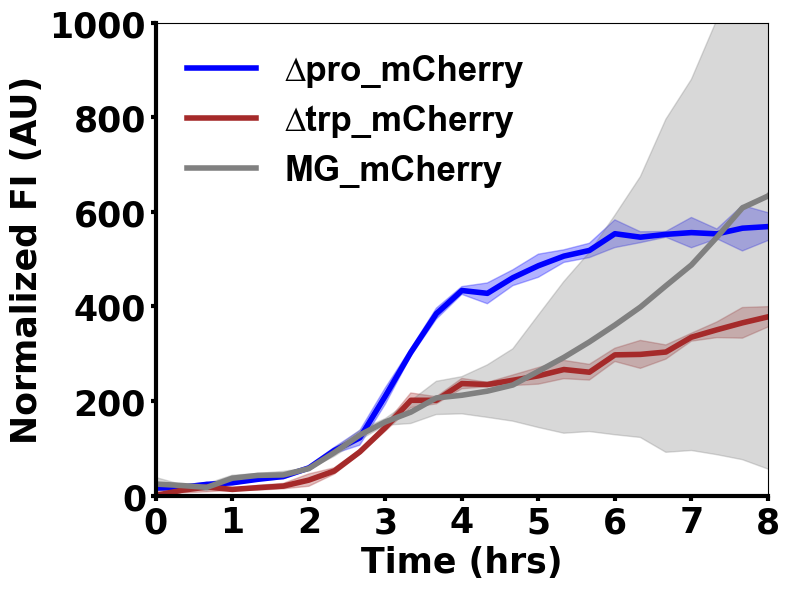

In [355]:
selected_columns = ["∆pro_mCherry", '∆trp_mCherry', 'MG_mCherry']
make_plot(autofluor_corrected, blank = 'fluor', xlim = (0, 8), ylim = (0, 1000), 
          ylabel = "Normalized FI (AU)", title = '5', s = True)

OD averaged by column name.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/OD averaged by column name.csv
LB blank_corrected OD.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/LB blank_corrected OD.csv
Doubling times per replicate.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/Doubling times per replicate.csv
ANOVA p-value: 0.3095

Post-hoc Tukey HSD results:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
  Neg (MG) Neg (∆pro)   0.0249 0.3444 -0.0251  0.075  False
  Neg (MG) Neg (∆trp)   0.0021  0.991  -0.048 0.0522  False
Neg (∆pro) Neg (∆trp)  -0.0228 0.3991 -0.0729 0.0272  False
-------------------------------------------

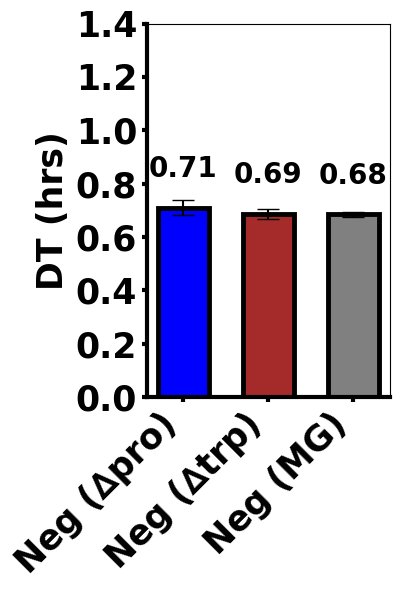

In [294]:
# Step 0: Define selected strains
selected_strains = ['Neg (∆pro)','Neg (∆trp)', 'Neg (MG)']

# Step 1: Get the averaged blank
averaged = avg()

# Step 2: Extract selected replicates and add averaged blank
selected_data = data[['Time (hrs)'] + selected_strains].copy()
selected_data['LB'] = averaged['LB']

# Step 3: Deduplicate columns to avoid pandas alignment errors
selected_data.columns = deduplicate_columns(selected_data.columns)

# Step 4: Run blank correction using your existing function
blank_corrected = blank_correct(blank='LB', df=selected_data, exp_type=exp_type, p=False)


# Rename all columns except 'Time (hrs)'
cols = blank_corrected.columns
blank_corrected.columns = [cols[0]] + [remove_suffix(c) for c in cols[1:]]


# Step 5: Continue to doubling time and stats
doubling_times_selected = calculate_doubling_times_per_replicate(blank_corrected, p=False)

run_statistical_analysis(doubling_times_selected, selected_strains=selected_strains)

# Step 8: Group by sample and calculate mean + std dev
summary_df = doubling_times_selected.groupby('Sample').agg(
    mean=('Doubling Time (hrs)', 'mean'),
    std=('Doubling Time (hrs)', 'std')
).reset_index()

summary_df.columns = ['Sample', 'Doubling Time (hrs)', 'Error']

# ✅ Reorder the rows to match selected_strains
summary_df = summary_df.set_index('Sample').loc[selected_strains].reset_index()


# ✅ Optional: save this for plotting
save_csv(summary_df, "Doubling time summary (mean + std).csv")


make_bar_plot(summary_df, barwidth = 0.6, blank='straintest', 
              title="Doubling Time of Selected Strains 1", 
             ylim = (0, 1.4), 
             figsize = (4,6), 
             s = True)

OD averaged by column name.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/OD averaged by column name.csv
LB blank_corrected OD.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/LB blank_corrected OD.csv
Doubling times per replicate.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/Doubling times per replicate.csv
ANOVA p-value: 0.9306

Post-hoc Tukey HSD results:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1      group2    meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
∆pro_sfGFP ∆trp_mCherry  -0.0029 0.9306 -0.0884 0.0827  False
-------------------------------------------------------------
Doubling time summary (mean + std).csv successfully saved to /Users/peirongli/Desktop/importa

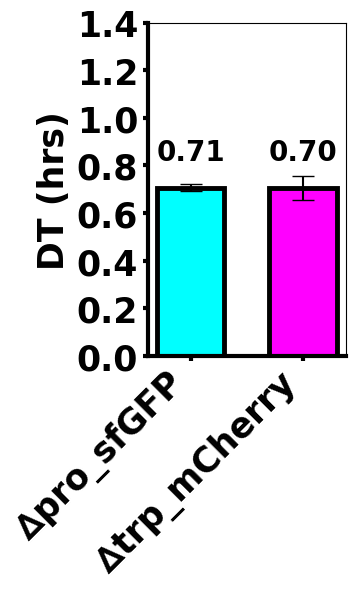

In [295]:
# Step 0: Define selected strains
selected_strains = ['∆pro_sfGFP', '∆trp_mCherry']

# Step 1: Get the averaged blank
averaged = avg()

# Step 2: Extract selected replicates and add averaged blank
selected_data = data[['Time (hrs)'] + selected_strains].copy()
selected_data['LB'] = averaged['LB']

# Step 3: Deduplicate columns to avoid pandas alignment errors
selected_data.columns = deduplicate_columns(selected_data.columns)

# Step 4: Run blank correction using your existing function
blank_corrected = blank_correct(blank='LB', df=selected_data, exp_type=exp_type, p=False)


# Rename all columns except 'Time (hrs)'
cols = blank_corrected.columns
blank_corrected.columns = [cols[0]] + [remove_suffix(c) for c in cols[1:]]


# Step 5: Continue to doubling time and stats
doubling_times_selected = calculate_doubling_times_per_replicate(blank_corrected, p=False)

run_statistical_analysis(doubling_times_selected, selected_strains=selected_strains)

# Step 8: Group by sample and calculate mean + std dev
summary_df = doubling_times_selected.groupby('Sample').agg(
    mean=('Doubling Time (hrs)', 'mean'),
    std=('Doubling Time (hrs)', 'std')
).reset_index()

summary_df.columns = ['Sample', 'Doubling Time (hrs)', 'Error']

# ✅ Reorder the rows to match selected_strains
summary_df = summary_df.set_index('Sample').loc[selected_strains].reset_index()


# ✅ Optional: save this for plotting
save_csv(summary_df, "Doubling time summary (mean + std).csv")


make_bar_plot(summary_df, barwidth = 0.6, blank='straintest', 
              title="Doubling Time of Selected Strains 3", 
             ylim = (0, 1.4), 
             figsize = (3.5,6), 
             s = True)

OD averaged by column name.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/OD averaged by column name.csv
LB blank_corrected OD.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/LB blank_corrected OD.csv
Doubling times per replicate.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/Doubling times per replicate.csv
ANOVA p-value: 0.5024

Post-hoc Tukey HSD results:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower  upper  reject
------------------------------------------------------------
∆pro_mCherry ∆trp_sfGFP  -0.0279 0.5024 -0.133 0.0772  False
------------------------------------------------------------
Doubling time summary (mean + std).csv successfully saved to /Users/peirongli/Desktop/important ti

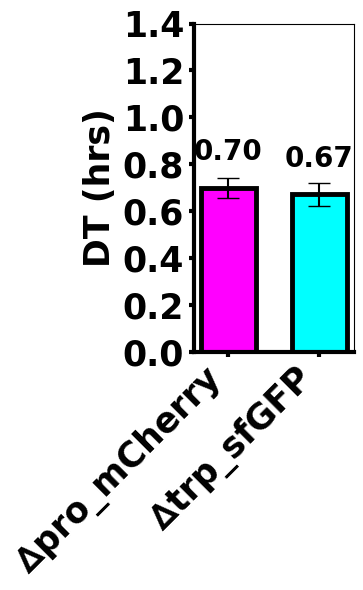

In [296]:
# Step 0: Define selected strains
selected_strains = ['∆pro_mCherry', '∆trp_sfGFP']

# Step 1: Get the averaged blank
averaged = avg()

# Step 2: Extract selected replicates and add averaged blank
selected_data = data[['Time (hrs)'] + selected_strains].copy()
selected_data['LB'] = averaged['LB']

# Step 3: Deduplicate columns to avoid pandas alignment errors
selected_data.columns = deduplicate_columns(selected_data.columns)

# Step 4: Run blank correction using your existing function
blank_corrected = blank_correct(blank='LB', df=selected_data, exp_type=exp_type, p=False)


# Rename all columns except 'Time (hrs)'
cols = blank_corrected.columns
blank_corrected.columns = [cols[0]] + [remove_suffix(c) for c in cols[1:]]


# Step 5: Continue to doubling time and stats
doubling_times_selected = calculate_doubling_times_per_replicate(blank_corrected, p=False)

run_statistical_analysis(doubling_times_selected, selected_strains=selected_strains)

# Step 8: Group by sample and calculate mean + std dev
summary_df = doubling_times_selected.groupby('Sample').agg(
    mean=('Doubling Time (hrs)', 'mean'),
    std=('Doubling Time (hrs)', 'std')
).reset_index()

summary_df.columns = ['Sample', 'Doubling Time (hrs)', 'Error']

# ✅ Reorder the rows to match selected_strains
summary_df = summary_df.set_index('Sample').loc[selected_strains].reset_index()


# ✅ Optional: save this for plotting
save_csv(summary_df, "Doubling time summary (mean + std).csv")


make_bar_plot(summary_df, barwidth = 0.6, blank='straintest', 
              title="Doubling Time of Selected Strains 2", 
             ylim = (0, 1.4), 
             figsize = (3.5,6), 
             s = True)

OD averaged by column name.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/OD averaged by column name.csv
LB blank_corrected OD.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/LB blank_corrected OD.csv
Doubling times per replicate.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/Doubling times per replicate.csv
ANOVA p-value: 0.1010

Post-hoc Tukey HSD results:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj  lower  upper  reject
--------------------------------------------------------
MG_mCherry MG_sfGFP   0.0506 0.101 -0.0156 0.1169  False
--------------------------------------------------------
Doubling time summary (mean + std).csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 

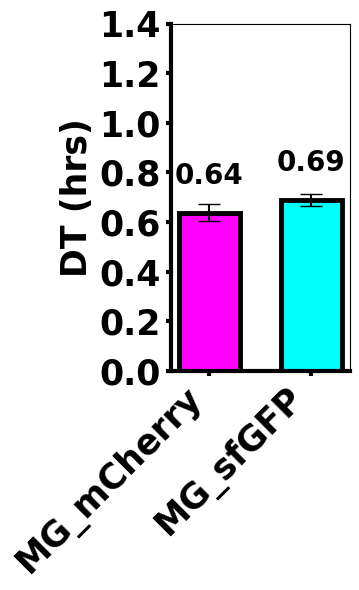

In [297]:
# Step 0: Define selected strains
selected_strains = ['MG_mCherry', 'MG_sfGFP']

# Step 1: Get the averaged blank
averaged = avg()

# Step 2: Extract selected replicates and add averaged blank
selected_data = data[['Time (hrs)'] + selected_strains].copy()
selected_data['LB'] = averaged['LB']

# Step 3: Deduplicate columns to avoid pandas alignment errors
selected_data.columns = deduplicate_columns(selected_data.columns)

# Step 4: Run blank correction using your existing function
blank_corrected = blank_correct(blank='LB', df=selected_data, exp_type=exp_type, p=False)


# Rename all columns except 'Time (hrs)'
cols = blank_corrected.columns
blank_corrected.columns = [cols[0]] + [remove_suffix(c) for c in cols[1:]]


# Step 5: Continue to doubling time and stats
doubling_times_selected = calculate_doubling_times_per_replicate(blank_corrected, p=False)

run_statistical_analysis(doubling_times_selected, selected_strains=selected_strains)

# Step 8: Group by sample and calculate mean + std dev
summary_df = doubling_times_selected.groupby('Sample').agg(
    mean=('Doubling Time (hrs)', 'mean'),
    std=('Doubling Time (hrs)', 'std')
).reset_index()

summary_df.columns = ['Sample', 'Doubling Time (hrs)', 'Error']

# ✅ Reorder the rows to match selected_strains
summary_df = summary_df.set_index('Sample').loc[selected_strains].reset_index()


# ✅ Optional: save this for plotting
save_csv(summary_df, "Doubling time summary (mean + std).csv")


make_bar_plot(summary_df, barwidth = 0.6, blank='straintest', 
              title="Doubling Time of Selected Strains 4", 
             ylim = (0, 1.4), 
             figsize = (3.5,6), 
             s = True)

OD averaged by column name.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/OD averaged by column name.csv
LB blank_corrected OD.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/LB blank_corrected OD.csv
Doubling times per replicate.csv successfully saved to /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/Doubling times per replicate.csv
ANOVA p-value: 0.2720

Post-hoc Tukey HSD results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
  MG_mCherry     MG_sfGFP   0.0506 0.6485  -0.045 0.1463  False
  MG_mCherry     Neg (MG)   0.0472 0.7224 -0.0484 0.1428  False
  MG_mCherry   Neg (∆pro)   0.0721 0.2355 -0.0235 0.1677  False
  MG_mCherry   Neg 

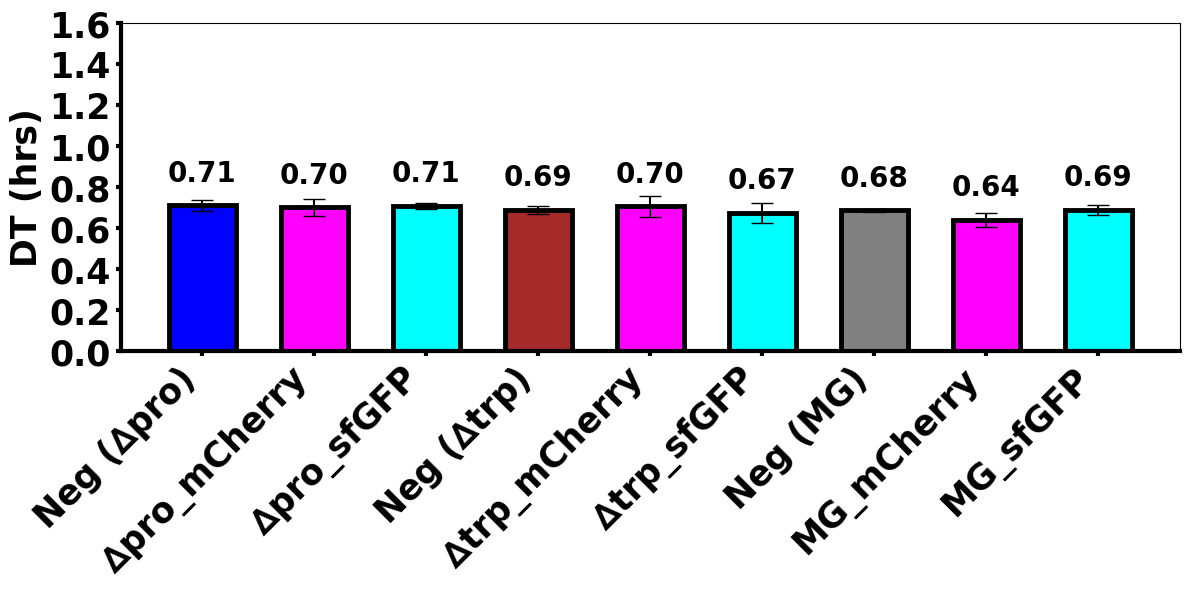

In [298]:
# Step 0: Define selected strains
selected_strains = ['Neg (∆pro)', '∆pro_mCherry', '∆pro_sfGFP', 'Neg (∆trp)', '∆trp_mCherry', '∆trp_sfGFP', 'Neg (MG)', 'MG_mCherry', 'MG_sfGFP']

# Step 1: Get the averaged blank
averaged = avg()

# Step 2: Extract selected replicates and add averaged blank
selected_data = data[['Time (hrs)'] + selected_strains].copy()
selected_data['LB'] = averaged['LB']

# Step 3: Deduplicate columns to avoid pandas alignment errors
selected_data.columns = deduplicate_columns(selected_data.columns)

# Step 4: Run blank correction using your existing function
blank_corrected = blank_correct(blank='LB', df=selected_data, exp_type=exp_type, p=False)


# Rename all columns except 'Time (hrs)'
cols = blank_corrected.columns
blank_corrected.columns = [cols[0]] + [remove_suffix(c) for c in cols[1:]]


# Step 5: Continue to doubling time and stats
doubling_times_selected = calculate_doubling_times_per_replicate(blank_corrected, p=False)

run_statistical_analysis(doubling_times_selected, selected_strains=selected_strains)

# Step 8: Group by sample and calculate mean + std dev
summary_df = doubling_times_selected.groupby('Sample').agg(
    mean=('Doubling Time (hrs)', 'mean'),
    std=('Doubling Time (hrs)', 'std')
).reset_index()

summary_df.columns = ['Sample', 'Doubling Time (hrs)', 'Error']

# ✅ Reorder the rows to match selected_strains
summary_df = summary_df.set_index('Sample').loc[selected_strains].reset_index()


# ✅ Optional: save this for plotting
save_csv(summary_df, "Doubling time summary (mean + std).csv")


make_bar_plot(summary_df, barwidth = 0.6, blank='straintest', 
              title="Doubling Time of Selected Strains 5", 
             ylim = (0, 1.6), 
             figsize = (12,6), 
             s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/04JUL25 int OD and fluor LB/figures/sup_no sup_CF.png


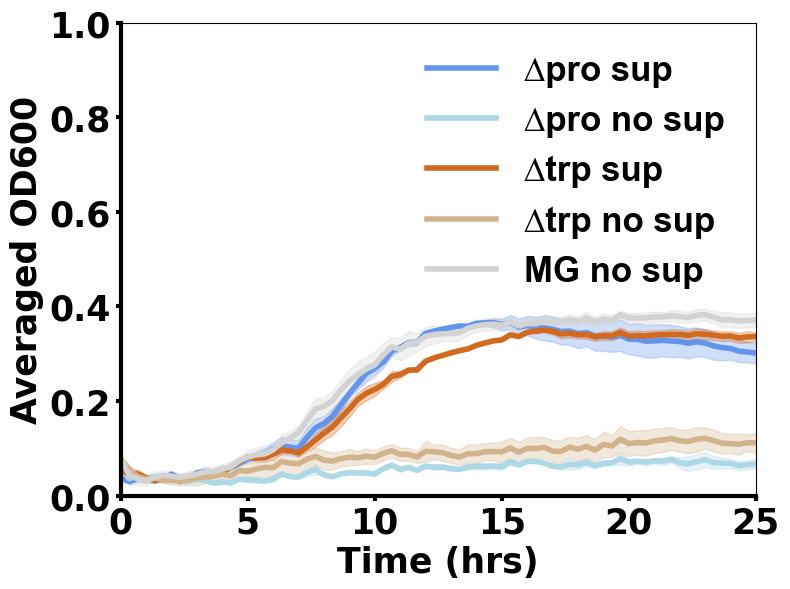

In [42]:
selected_columns = ["∆pro sup", "∆pro no sup", "∆trp sup", "∆trp no sup", "MG no sup"]
make_plot(blank_corrected_data, blank = 'CF', xlim = (0, 25), ylim = (0, 1), 
          ylabel = "Averaged OD600", title = 'sup_no sup_CF', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/figures/1.png


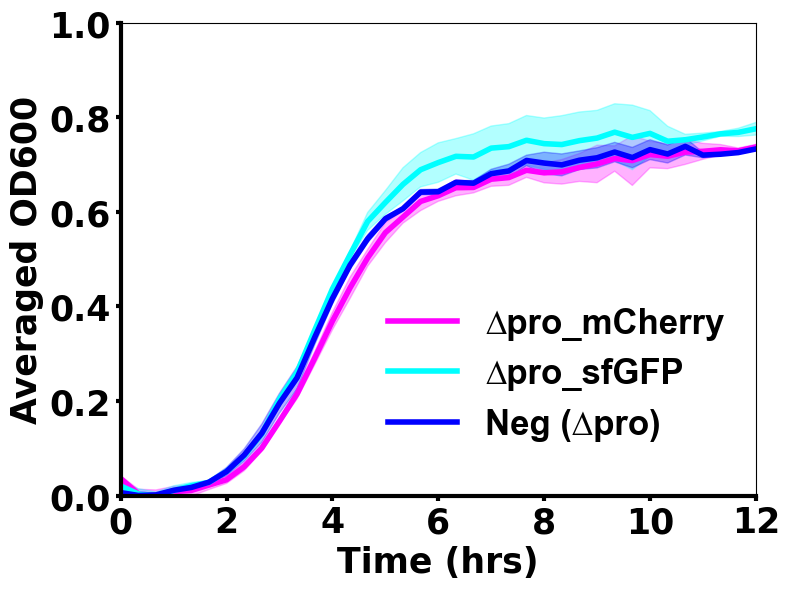

In [291]:
selected_columns = ["∆pro_mCherry", "∆pro_sfGFP", "Neg (∆pro)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 12), ylim = (0, 1), 
          ylabel = "Averaged OD600", title = '1', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/figures/2.png


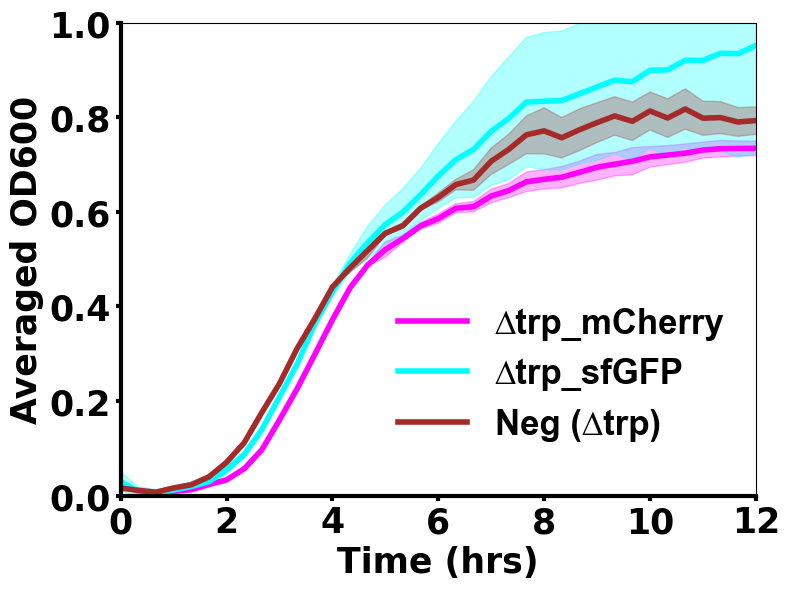

In [292]:
selected_columns = ["∆trp_mCherry", "∆trp_sfGFP", "Neg (∆trp)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 12), ylim = (0, 1), 
          ylabel = "Averaged OD600", title = '2', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/figures/3.png


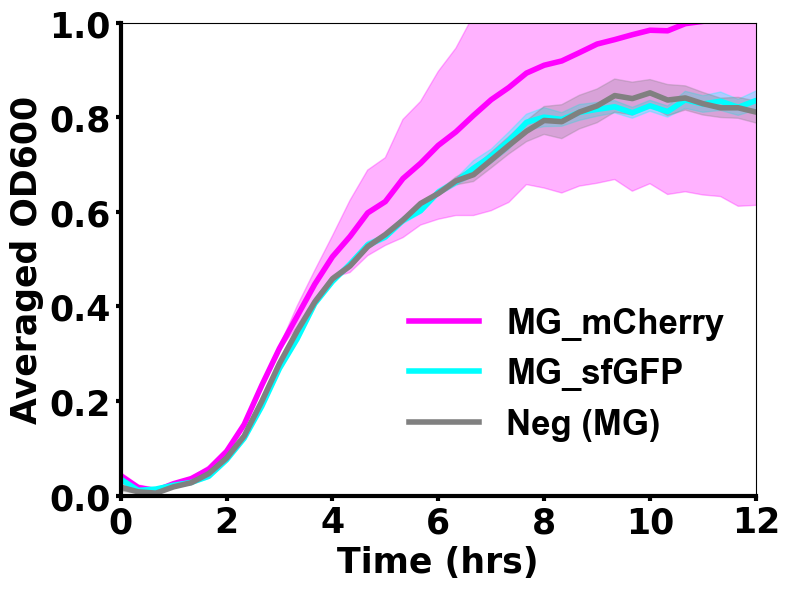

In [293]:
selected_columns = ["MG_mCherry", "MG_sfGFP", 'Neg (MG)']
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 12), ylim = (0, 1), 
          ylabel = "Averaged OD600", title = '3', s = True)


figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/08AUG25 int OD and fluor LB/figures/6.png


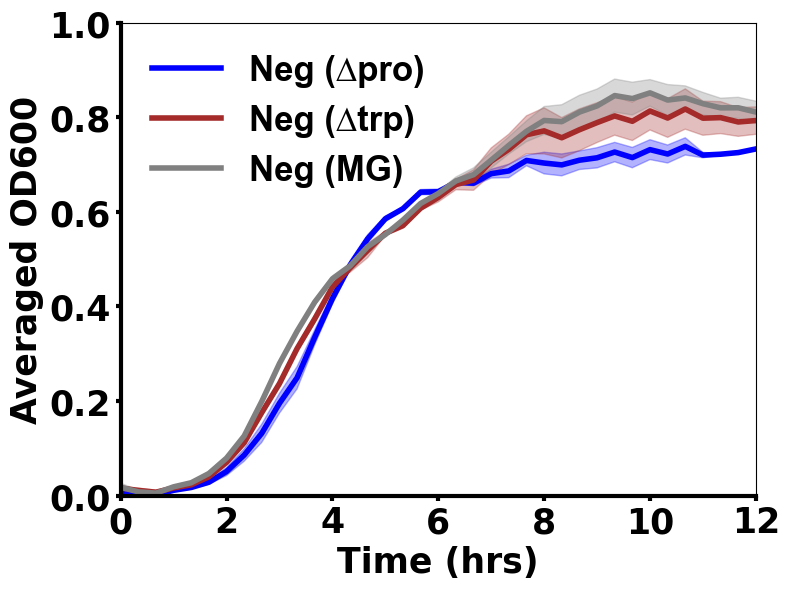

In [363]:
selected_columns = ["Neg (∆pro)", "Neg (∆trp)", 'Neg (MG)']
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 12), ylim = (0, 1), 
          ylabel = "Averaged OD600", title = '6', s = True)


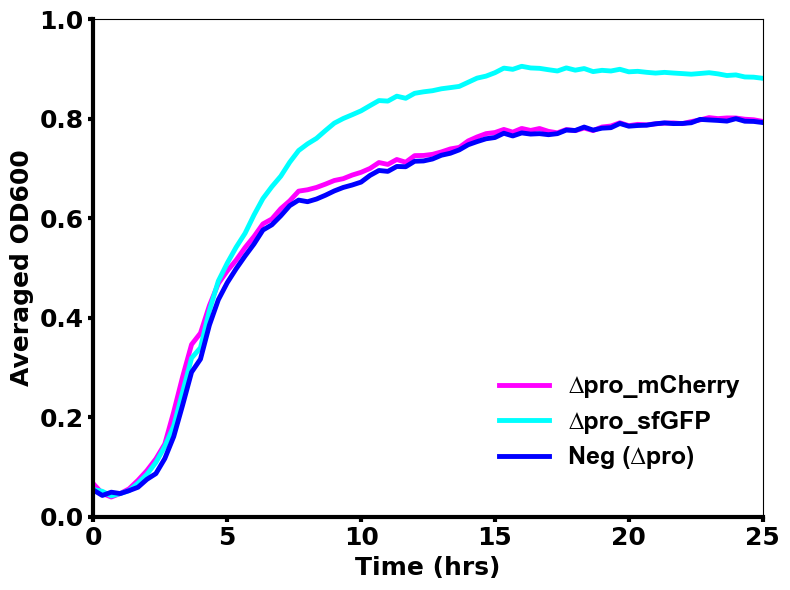

In [189]:
selected_columns = ["∆pro_mCherry", "∆pro_sfGFP", "Neg (∆pro)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 25), ylim = (0, 1), 
          ylabel = "Averaged OD600", title = '1', s = False)

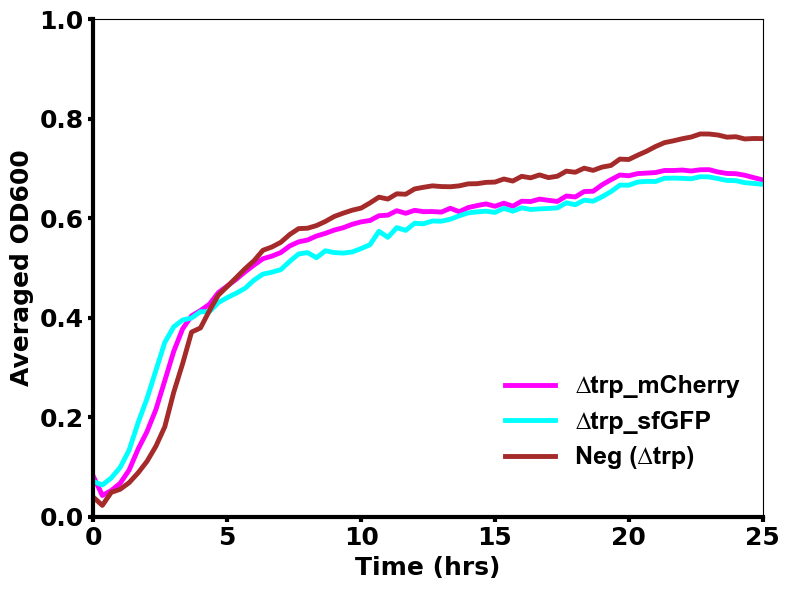

In [190]:
selected_columns = ["∆trp_mCherry", "∆trp_sfGFP", "Neg (∆trp)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 25), ylim = (0, 1), 
          ylabel = "Averaged OD600", title = '2', s = False)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/22JUL25 int OD and fluor M9/figures/sup_no sup_CF.png


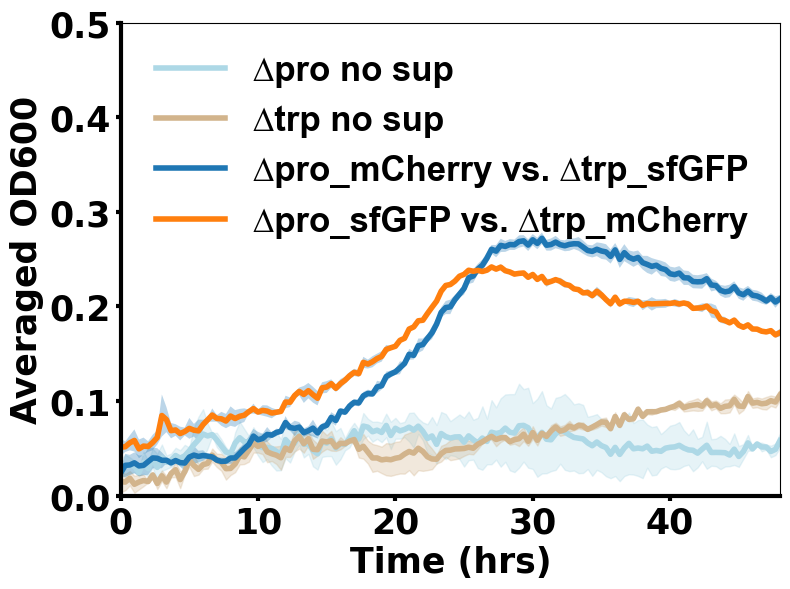

In [47]:
selected_columns = ["∆pro no sup", "∆trp no sup", "∆pro_mCherry vs. ∆trp_sfGFP", "∆pro_sfGFP vs. ∆trp_mCherry"]
make_plot(blank_corrected_data, blank = 'CF', xlim = (0, 48), ylim = (0, 0.5), 
          ylabel = "Averaged OD600", title = 'sup_no sup_CF', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/18JUN25 plasmid-based OD and fluor/figures/1.png


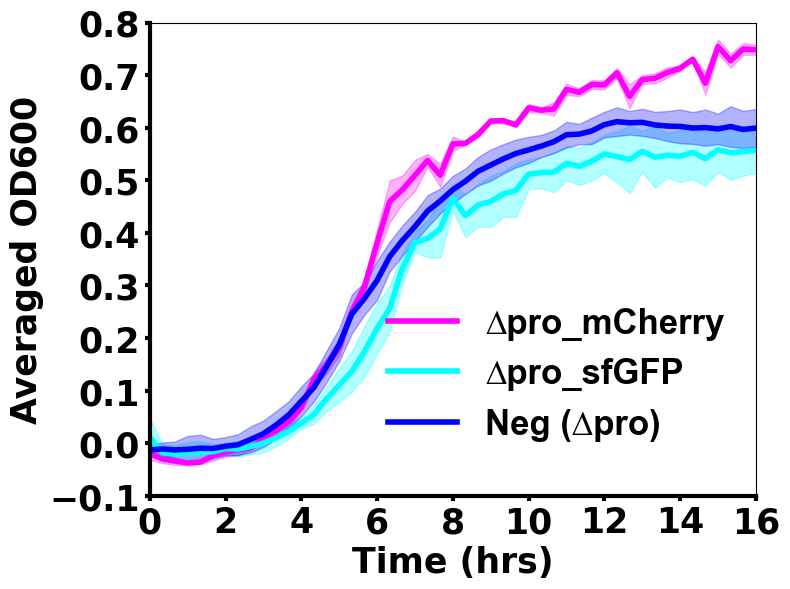

In [62]:
selected_columns = ["∆pro_mCherry", "∆pro_sfGFP", "Neg (∆pro)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 16), ylim = (-0.1, 0.8), 
          ylabel = "Averaged OD600", title = '1', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/18JUN25 plasmid-based OD and fluor/figures/2.png


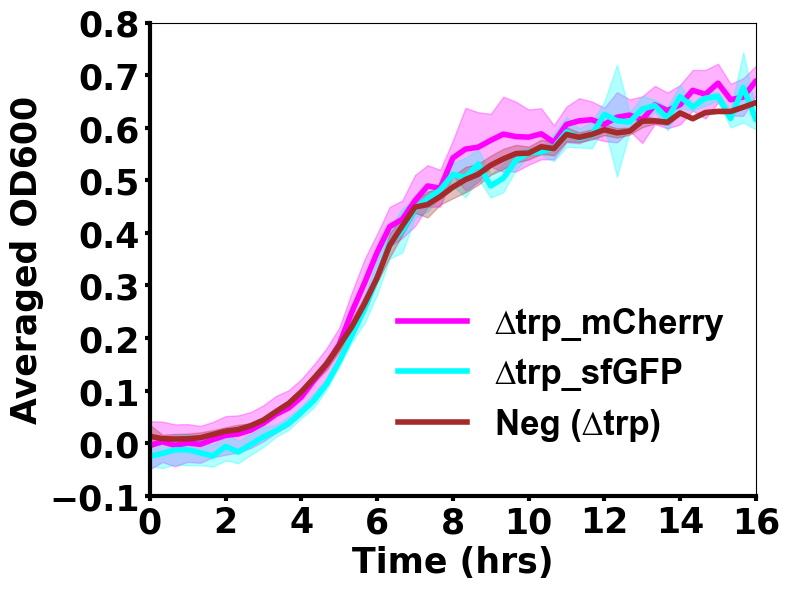

In [63]:
selected_columns = ["∆trp_mCherry", "∆trp_sfGFP", "Neg (∆trp)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 16), ylim = (-0.1, 0.8), 
          ylabel = "Averaged OD600", title = '2', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/18JUN25 plasmid-based OD and fluor/figures/3.png


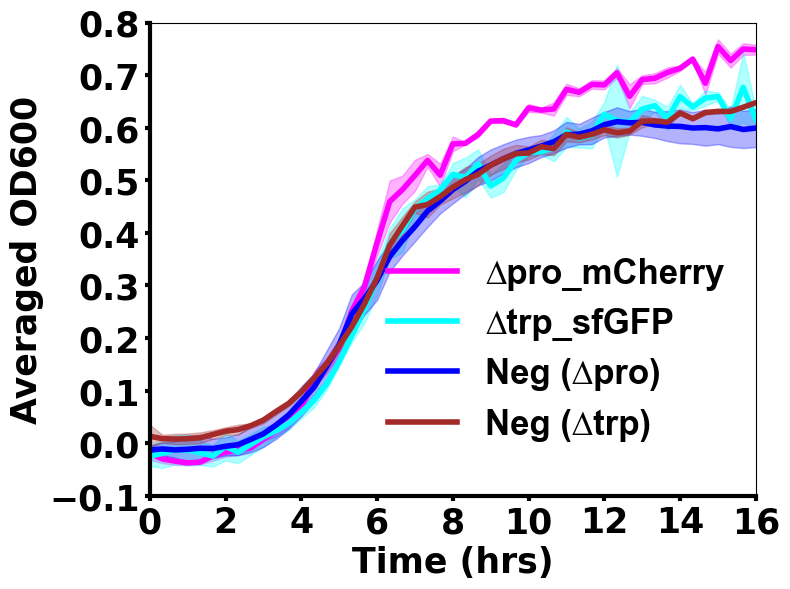

In [64]:
selected_columns = ["∆pro_mCherry", "∆trp_sfGFP", "Neg (∆pro)", "Neg (∆trp)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 16), ylim = (-0.1, 0.8), 
          ylabel = "Averaged OD600", title = '3', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/18JUN25 plasmid-based OD and fluor/figures/4.png


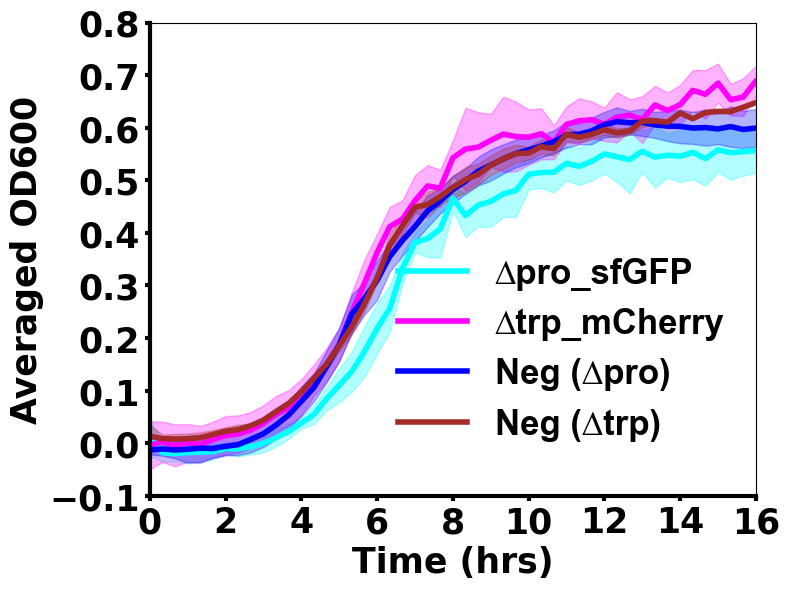

In [65]:
selected_columns = ["∆pro_sfGFP", "∆trp_mCherry", "Neg (∆pro)", "Neg (∆trp)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 16), ylim = (-0.1, 0.8), 
          ylabel = "Averaged OD600", title = '4', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/18JUN25 plasmid-based OD and fluor/figures/5.png


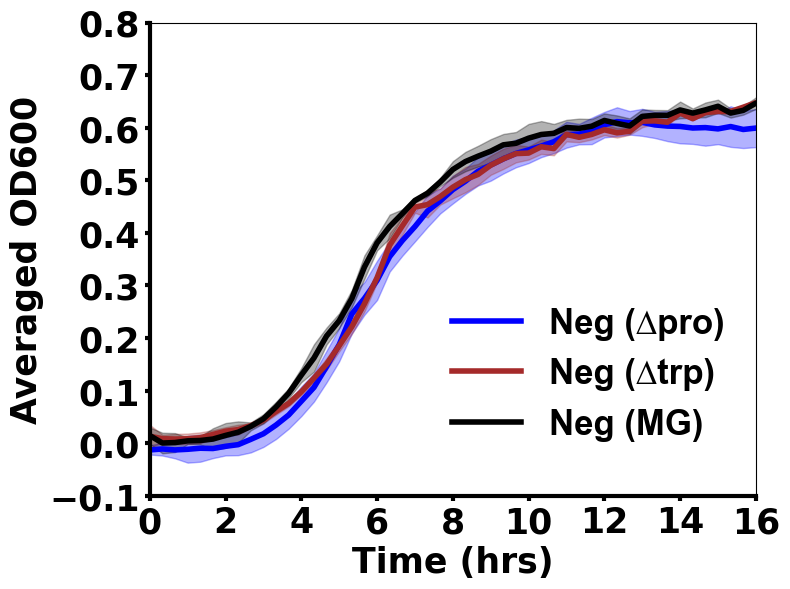

In [56]:
selected_columns = ["Neg (∆pro)", "Neg (∆trp)", "Neg (MG)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 16), ylim = (-0.1, 0.8), 
          ylabel = "Averaged OD600", title = '5', s = True)

figures saved to: /Users/peirongli/Desktop/important tings/1. MRes/Project 2/Plate reader/18JUN25 plasmid-based OD and fluor/figures/6.png


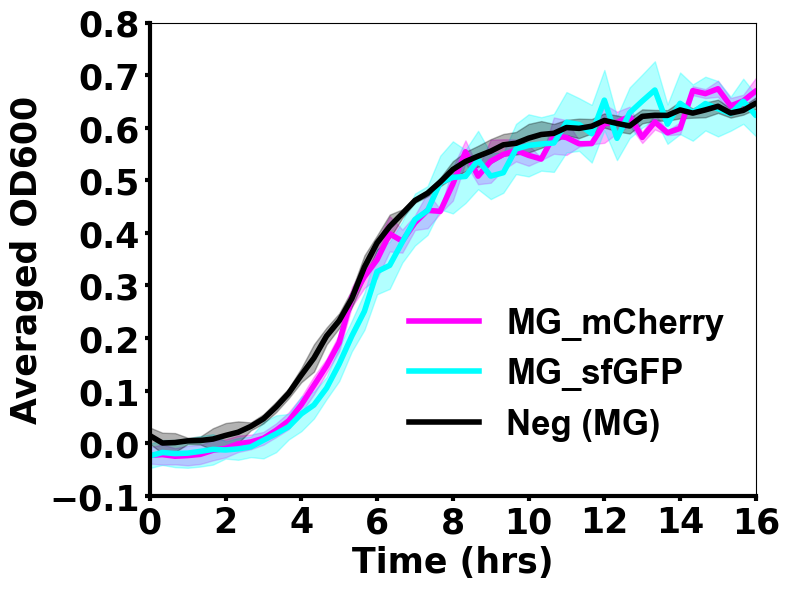

In [57]:
selected_columns = ["MG_mCherry", "MG_sfGFP", "Neg (MG)"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 16), ylim = (-0.1, 0.8), 
          ylabel = "Averaged OD600", title = '6', s = True)

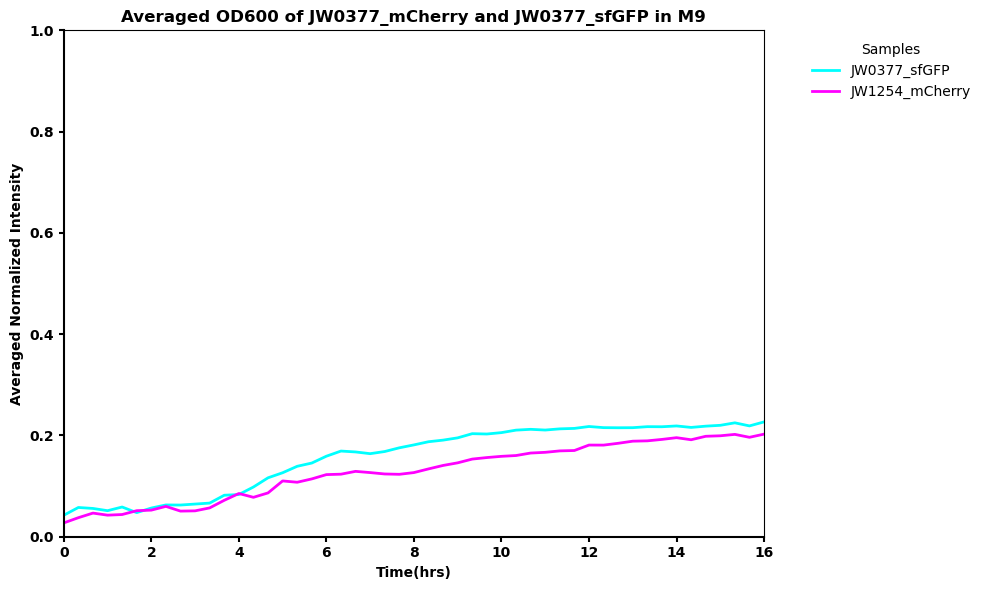

In [53]:
selected_columns = ["JW0377_sfGFP", "JW1254_mCherry"]
make_plot(blank_corrected_data, blank = 'straintest', xlim = (0, 16), ylim = (0, 1), 
          ylabel = "Averaged Normalized Intensity", title = "Averaged OD600 of JW0377_mCherry and JW0377_sfGFP in M9", s = False)



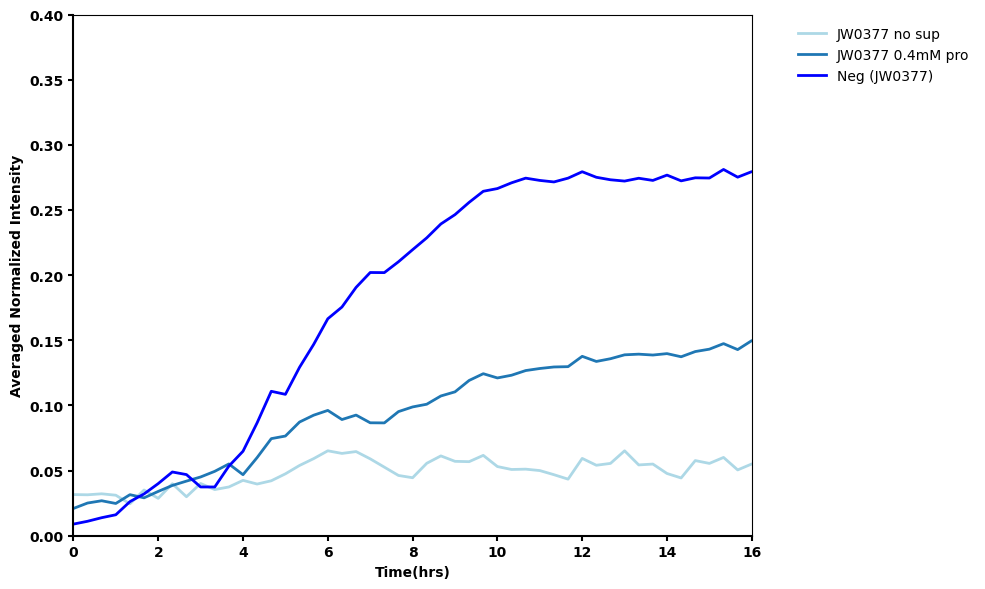

In [70]:
selected_columns = ["JW0377 no sup", "JW0377 0.4mM pro", "Neg (JW0377)"]
make_plot(blank_corrected_data, blank = 'CF', xlim = (0, 16), ylim = (0, 0.4), 
          ylabel = "Averaged Normalized Intensity", s = False)



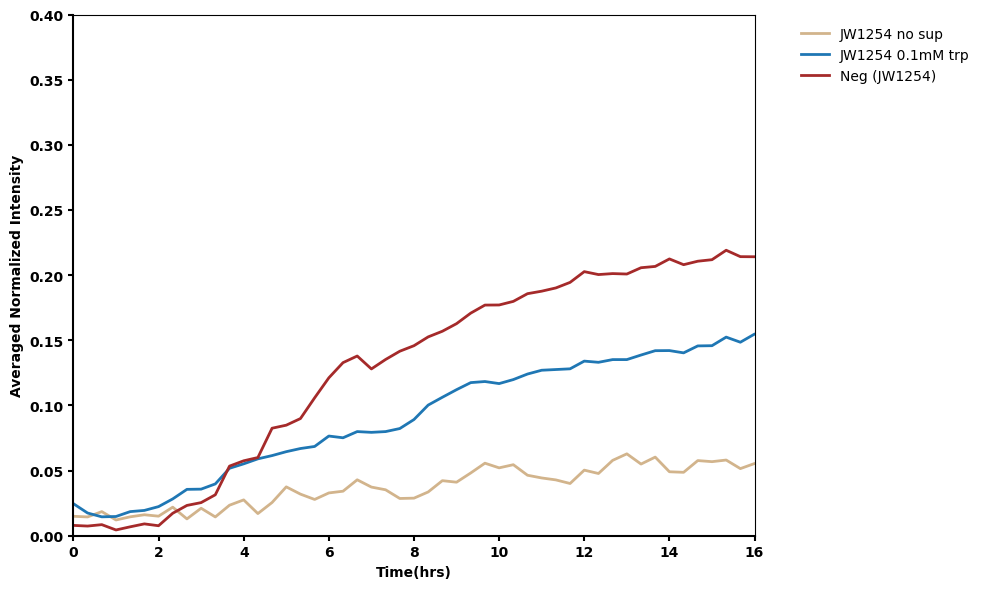

In [71]:
selected_columns = ["JW1254 no sup", "JW1254 0.1mM trp", "Neg (JW1254)"]
make_plot(blank_corrected_data, blank = 'CF', xlim = (0, 16), ylim = (0, 0.4), 
          ylabel = "Averaged Normalized Intensity", s = False)



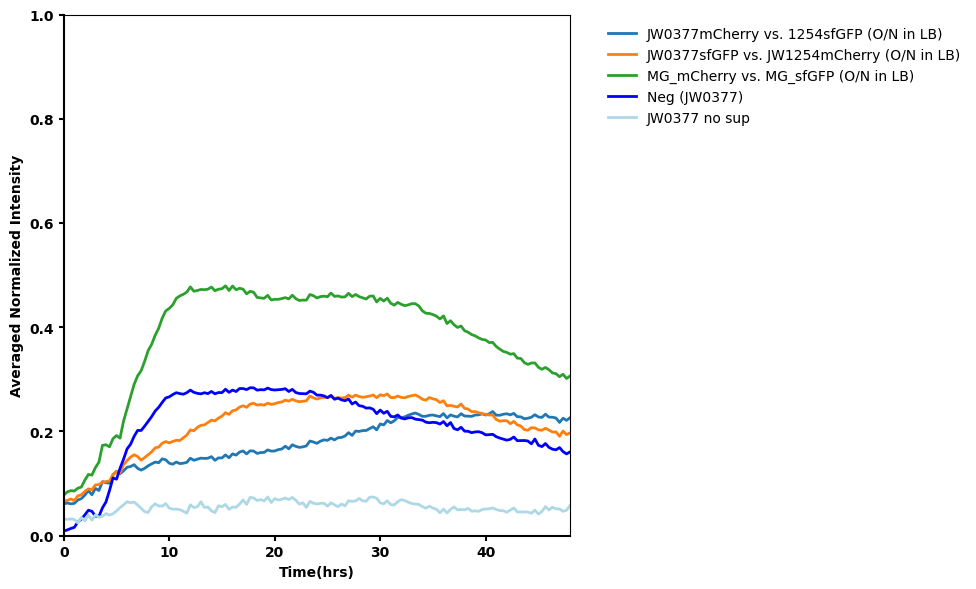

In [72]:
selected_columns = ["JW0377mCherry vs. 1254sfGFP (O/N in LB)", "JW0377sfGFP vs. JW1254mCherry (O/N in LB)", 
                  "MG_mCherry vs. MG_sfGFP (O/N in LB)", "Neg (JW0377)", "JW0377 no sup"
                    ]
make_plot(blank_corrected_data, blank = 'CF', xlim = (0, 48), ylim = (0, 1), 
          ylabel = "Averaged Normalized Intensity", s = False)

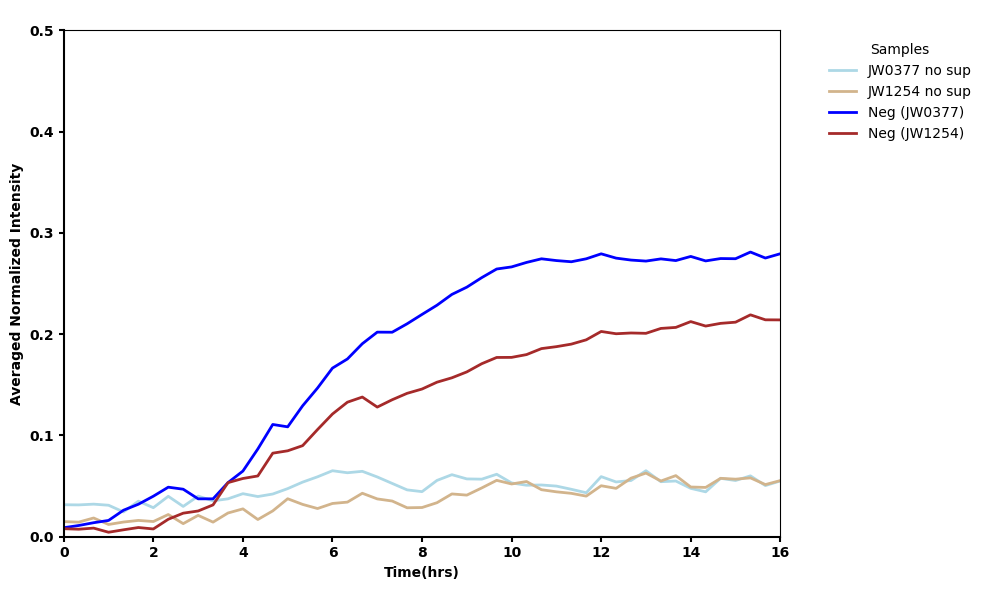

In [60]:
selected_columns = ["JW0377 no sup", "JW1254 no sup", "Neg (JW0377)", "Neg (JW1254)"]
make_plot(blank_corrected_data, blank = 'CF', xlim = (0, 16), ylim = (0, 0.5), 
          ylabel = "Averaged Normalized Intensity", title = " ", s = False)

